we used a pre trained transformer model named BERT on a GPU you in colab on WELfake dataset. Due to computational constraints the dateset was halfed for  accommodate the hard ware around 35,768 rows of data was used this model accepts 270 words max based on storage limitations it was trained on and BERT's limit of 510 words . The datasets was cleaned and checked to be balanced. 4 epochs ,a  batch size of 32 at a learning rate of 2e -5
it was found to give an accuracy of 82% and F1 score of 82%

# set enviroment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.5 MB/s eta 0:0

In [ ]:
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# specify GPU
device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import re

In [ ]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [ ]:
!pip freeze > requirements.txt

# import dataset

In [ ]:
news = pd.read_csv('WELFake_Dataset_tra.csv')
news = news.drop(columns = ['Unnamed: 0'])
# See how the data looks like
print(news.shape)
news.head()

(35134, 4)


,Unnamed: 0.1,title,text,label
0,37000,"Trump, Clinton Head Into SC with Fierce Compet...",The presidential candidates are laser-focused ...,0
1,37001,Estimated Enrollees for 2015 Health Care Decrease,About 9.9 million people will sign up to have ...,0
2,37002,Im no bloody wankah,I didn't know which one to do first or rather ...,1
3,37003,BUSTED: Trump Supporters Get Caught Creating F...,"on October 27, 2016 2:53 am · \nConservatives ...",1
4,37004,Exclusive: Trump EPA transition chief laments ...,WASHINGTON (Reuters) - The man who led Preside...,0


# Clean dataset

In [ ]:
print(news['label'].dtype)
print(news["title"].isna().sum())
print(news["text"].isna().sum())
news = news.dropna()
news.shape
news.head()

int64
299
22


,Unnamed: 0.1,title,text,label
0,37000,"Trump, Clinton Head Into SC with Fierce Compet...",The presidential candidates are laser-focused ...,0
1,37001,Estimated Enrollees for 2015 Health Care Decrease,About 9.9 million people will sign up to have ...,0
2,37002,Im no bloody wankah,I didn't know which one to do first or rather ...,1
3,37003,BUSTED: Trump Supporters Get Caught Creating F...,"on October 27, 2016 2:53 am · \nConservatives ...",1
4,37004,Exclusive: Trump EPA transition chief laments ...,WASHINGTON (Reuters) - The man who led Preside...,0


([<matplotlib.patches.Wedge at 0x7bd908151120>,
 [Text(-1.1995105745755261, -0.03426924979469599, 'Fake'),
  Text(1.1995105745755261, 0.034269249794695845, 'True')],
 [Text(-0.6997145018357236, -0.01999039571357266, '50.9%'),
  Text(0.6997145018357236, 0.019990395713572577, '49.1%')])

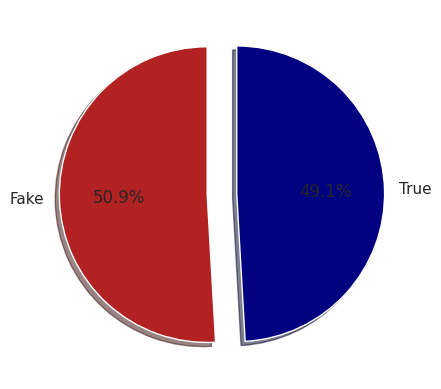

In [ ]:
label_size = [news['label'].sum(),len(news['label'])-news['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
news1 = news.copy()

# Word Count histogram





We use train set to perform exploratory analysis. First we want to look at the word count for each news and see if there is difference between real and fake news.





<Axes: xlabel='word_count'>

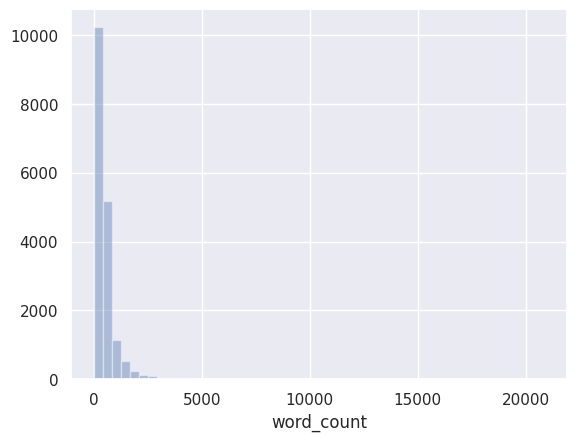

In [ ]:
news1['word_count'] = [len(s.split()) for s in news['text']]
#real
sns.distplot(news1['word_count'][news['label'] == 1], kde=False, rug=False)

<Axes: xlabel='word_count'>

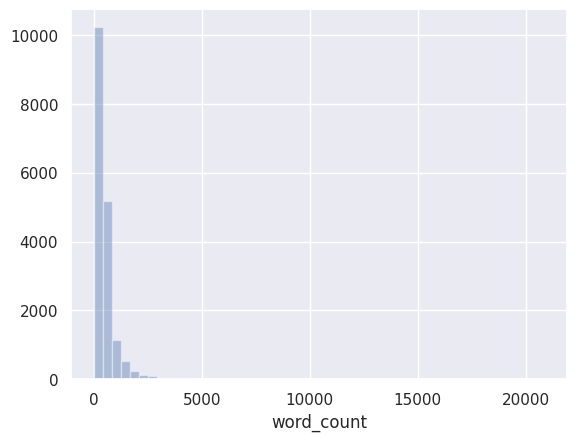

In [ ]:
#fake
sns.distplot(news1['word_count'][news1['label'] == 1], kde=False, rug=False)

As for the fake news, we see some outliers from above figure, making it hard to intepret, so we plot it again below with outlier (news that has more than 10,000 words) removed.

<Axes: xlabel='word_count'>

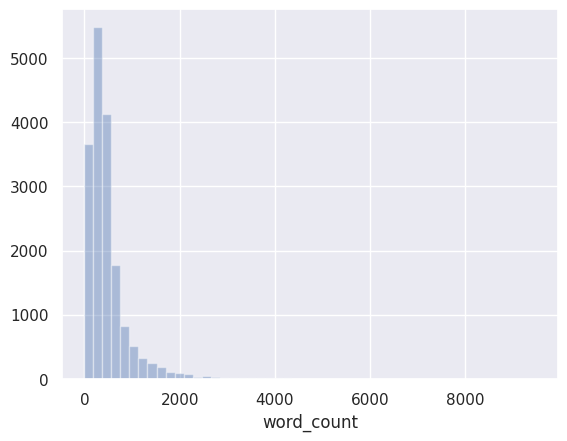

In [ ]:
sns.distplot(news1['word_count'][(news1['label'] == 1) & (news1['word_count'] < 10000)], kde=False, rug=False)

<Axes: xlabel='word_count'>

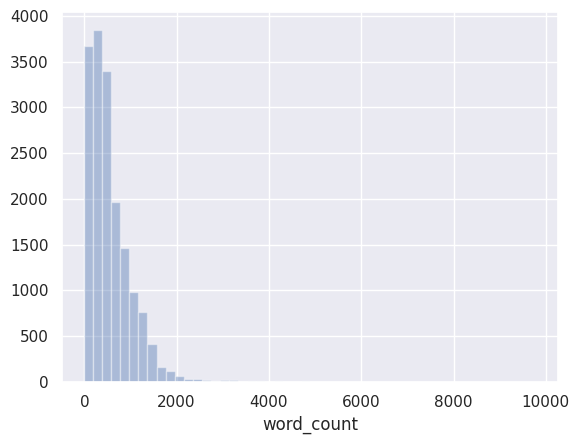

In [ ]:
sns.distplot(news1['word_count'][(news1['label'] == 0) & (news1['word_count'] < 10000)], kde=False, rug=False)

We can see the word count distribution of fake/real news are more skewed, most of the news have words below 2000.

# PREPROCESS

In [ ]:
news.head()

,Unnamed: 0.1,title,text,label
0,37000,"Trump, Clinton Head Into SC with Fierce Compet...",The presidential candidates are laser-focused ...,0
1,37001,Estimated Enrollees for 2015 Health Care Decrease,About 9.9 million people will sign up to have ...,0
2,37002,Im no bloody wankah,I didn't know which one to do first or rather ...,1
3,37003,BUSTED: Trump Supporters Get Caught Creating F...,"on October 27, 2016 2:53 am · \nConservatives ...",1
4,37004,Exclusive: Trump EPA transition chief laments ...,WASHINGTON (Reuters) - The man who led Preside...,0


We then remove non alphanumeric characters as well as converting to all lower case from the text.

In [ ]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

news['text'] = news['text'].apply(clean_txt)
news = news.sample(frac=0.9)
news.shape

(31332, 4)

In [ ]:

news['text'] = news['title'] + ' ' + news['text']
news.head()

,Unnamed: 0.1,title,text,label
22588,59588,Muslims Are Kidnapping White Girls And Forcing...,Muslims Are Kidnapping White Girls And Forcing...,1
33385,70385,American Funhouse: Manufacturing Consent,American Funhouse: Manufacturing Consent behin...,1
31840,68840,WHY TRUMP’S OWN CHILDREN WON’T Be Voting For H...,WHY TRUMP’S OWN CHILDREN WON’T Be Voting For H...,1
2489,39489,WATCH “ARCHITECT” OF OBAMACARE Lie And Spin Hi...,WATCH “ARCHITECT” OF OBAMACARE Lie And Spin Hi...,1
5977,42977,Irish border row thwarts May bid to clinch Bre...,Irish border row thwarts May bid to clinch Bre...,0


([<matplotlib.patches.Wedge at 0x7bd90060a680>,
 [Text(-1.1994715220190133, -0.03560994054182212, 'Fake'),
  Text(1.1994715220190133, 0.03560994054182198, 'True')],
 [Text(-0.6996917211777576, -0.020772465316062905, '50.9%'),
  Text(0.6996917211777576, 0.02077246531606282, '49.1%')])

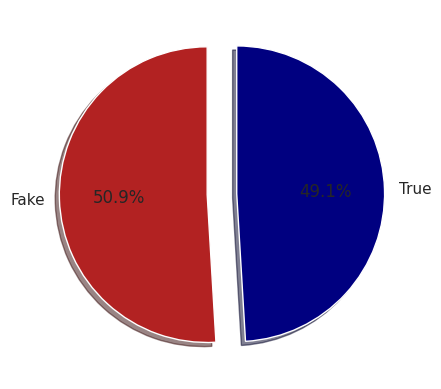

In [ ]:
label_size = [news['label'].sum(),len(news['label'])-news['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

### SPLIT DATASET

First we like to split our training set into training and validation set with a ratio of 8:2, this way we can use the validation to tune our model, and finally predict on the hold out test set.

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(news['text'], news['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=news['label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# BERT

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Next we preprocess our original text into input features BERT can read. The process is basically tokenizing and coverting our original text into token ids that can be read by the algorithm. The words are tokenized base on the vocabulary dictionary it pretrained on(about 30,000 words), and unknown words are breaken down into smaller words contained in the dictionary. Maximum sequence length are also specified so we can pad all sequence into the same length.
Note: The final sequence length would be larger than specified since BERT tokenizer will break unknown words into multiple small known words.

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).describe()

count    21932.000000
mean       565.522615
std        640.975038
min          3.000000
25%        248.000000
50%        420.000000
75%        693.000000
max      21314.000000
dtype: float64

In [ ]:
# Majority of titles above have word length under 568. So, we set max title length as 250 sice bert max is 510 words and to save storage
MAX_LENGHT = 270
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### freeze parameters

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
model.cuda()
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 25

### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = tuple(t.to(device) for t in batch)                                 # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = tuple(t.to(device) for t in batch)                   # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c3_new_model_weights.pt')
    train_losses.append(train_loss)           # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 25
  Batch    50  of    686.
  Batch   100  of    686.
  Batch   150  of    686.
  Batch   200  of    686.
  Batch   250  of    686.
  Batch   300  of    686.
  Batch   350  of    686.
  Batch   400  of    686.
  Batch   450  of    686.
  Batch   500  of    686.
  Batch   550  of    686.
  Batch   600  of    686.
  Batch   650  of    686.

Evaluating...
  Batch    50  of    147.
  Batch   100  of    147.

Training Loss: 0.505
Validation Loss: 0.481

 Epoch 2 / 25
  Batch    50  of    686.
  Batch   100  of    686.
  Batch   150  of    686.
  Batch   200  of    686.
  Batch   250  of    686.
  Batch   300  of    686.
  Batch   350  of    686.
  Batch   400  of    686.
  Batch   450  of    686.
  Batch   500  of    686.
  Batch   550  of    686.
  Batch   600  of    686.
  Batch   650  of    686.

Evaluating...
  Batch    50  of    147.
  Batch   100  of    147.

Training Loss: 0.488
Validation Loss: 0.489

 Epoch 3 / 25
  Batch    50  of    686.
  Batch   100  of    686.
  B

In [ ]:
ep = list(range(epoch+2))[1:]
ep

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

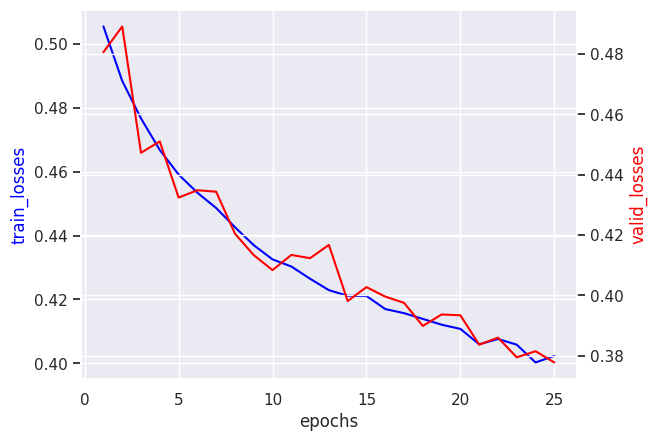

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with two variables
df = pd.DataFrame({
    "epoch": ep,
    "train_losses": train_losses,
    "valid_losses": valid_losses
})

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the first variable on the left y-axis
ax.plot(df["epoch"], df["train_losses"], color="blue")

# Plot the second variable on the right y-axis
ax2 = ax.twinx()
ax2.plot(df["epoch"], df["valid_losses"], color="red")

# Set the y-axis labels
ax.set_ylabel("train_losses", color="blue")
ax2.set_ylabel("valid_losses", color="red")


# Set the x-axis label
ax.set_xlabel("epochs")

# Show the plot
plt.show()

In [ ]:
torch.save(model,'Fakefinal')